<a href="https://colab.research.google.com/github/Oliz888/Voting_Consensus_Detection/blob/main/voting_and_consensus_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
### Setting up Google Colab (optional) ###
# Installing necessary packages
!pip install python-igraph
!pip install leidenalg
!pip install umap-learn
!pip install umap-learn -i https://mirrors.ustc.edu.cn/pypi/web/simple

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.2 MB 3.6 MB/s 
  Created wheel for python-igraph: filename=python_igraph-0.10.2-py3-none-any.whl size=9074 sha256=7c6f46c577064dc6ba1f16213bee0b6eeb3b83bcbea7940347e2464bf30c9d58
  Stored in directory: /root/.cache/pip/wheels/74/1d/33/83ec153aa37c92957b2edb888f4f42fdea9b7ac89f4b919391
Successfully built python-igraph
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 3.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.0 MB/s 
     |████████████████████████████████| 1.1 MB 20.1 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=e46efebe9a79e9f2928e86c07827aa2a99ae4237c0b3565e2756aae549d38098
  Stored in d

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt
from textwrap import wrap
from sklearn.neighbors import kneighbors_graph

import umap.umap_ as umap
# import umap

import igraph as ig
import leidenalg

from sklearn.decomposition import PCA



In [ ]:
# Getting access to Google Drive files (participants-votes.csv etc)
from google.colab import drive
drive.mount("/content/drive")

df_comments= pd.read_csv("/content/drive/MyDrive/Colab Notebooks/comments.csv")
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/participants-votes.csv")

Mounted at /content/drive


In [ ]:
df_comments.head()

,timestamp,datetime,comment-id,author-id,agrees,disagrees,moderated,comment-body
0,1472552518501,Tue Aug 30 17:21:58 WIB 2016,194,4413,1,0,0,Uber的出現 因服務內容明確、平台簡潔、交易程序精簡、路線糾紛減少，並有評價機制穩定服務雙...
1,1472403087787,Sun Aug 28 23:51:27 WIB 2016,187,4378,1,0,0,uber就是叫派計程車，談不上運用閒置資源或是共乘
2,1451878620176,Mon Jan 04 10:37:00 WIB 2016,183,4120,1,0,0,探討法律、稅務、安全等問題時，應先理解供需，為什麼民眾會選擇Uber？簡單說就是機會成本的選...
3,1438228490557,Thu Jul 30 10:54:50 WIB 2015,138,1476,1,0,-1,Uner只不過是用多餘的時間來賺取微薄的收入，黃牌不用繳交所得稅外還有補助，那麼我們上班族都...
4,1438155033741,Wed Jul 29 14:30:33 WIB 2015,130,1960,1,0,-1,我覺得搭乘時完全不用擔心身上太多的零錢或是找不開的金額鈔票，一來可以讓司機放心身上不用帶太多...


In [ ]:
df_comments.shape

(197, 8)

In [ ]:
df_comments.dtypes

timestamp        int64
datetime        object
comment-id       int64
author-id        int64
agrees           int64
disagrees        int64
moderated        int64
comment-body    object
dtype: object

Including the comments being moderated out, there are 197 comments and 8 vals including the datetime, index of comments, id of author, and the general stands of this comments (agree/disagree) with the uber issue

In [ ]:
df.shape

(1921, 203)

In [ ]:
df.describe()

,participant,group-id,n-comments,n-votes,n-agree,n-disagree,0,1,2,3,...,187,188,189,190,191,192,193,194,195,196
count,1921.000000,1219.000000,1921.000000,1921.000000,1921.000000,1921.000000,764.00000,9.000000,10.000000,760.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
mean,2541.974492,0.729286,0.102551,25.738157,16.152525,6.191567,0.40445,-0.666667,-0.500000,0.525000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
std,1587.214738,0.444511,1.120546,27.124417,18.148495,8.415372,0.85366,0.707107,0.849837,0.804733,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-1.00000,-1.000000,-1.000000,-1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
25%,979.000000,0.000000,0.000000,3.000000,1.000000,0.000000,0.00000,-1.000000,-1.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
50%,2611.000000,1.000000,0.000000,15.000000,8.000000,3.000000,1.00000,-1.000000,-1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
75%,4187.000000,1.000000,0.000000,42.000000,26.000000,10.000000,1.00000,-1.000000,-0.250000,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
max,4667.000000,1.000000,46.000000,101.000000,87.000000,55.000000,1.00000,1.000000,1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
df['group-id'][df['group-id'] == 1.0].count()

889

In [ ]:
df['group-id'][df['group-id'] == 1.0].count()
df['group-id'][df['group-id'] == 0.0].count()

330

In [ ]:
df.head()

,participant,group-id,n-comments,n-votes,n-agree,n-disagree,0,1,2,3,...,187,188,189,190,191,192,193,194,195,196
0,0,0.0,46,101,44,12,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,29,14,10,1.0,-1.0,-1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1.0,5,88,58,15,1.0,-1.0,-1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1.0,0,31,13,16,1.0,-1.0,-1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1.0,0,11,0,0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Including the partipants vote less than 7 votes, which would be removed from the valid voters list. There are 1921 voters, and 203 vals: including the meta data of their votes, and their opinion on each comments.

In [ ]:
df_comments.index = df_comments.index.astype(str)

In [ ]:
# remove statements (columns) which were moderated out
statements_all_in = sorted(list(df_comments.loc[df_comments["moderated"] > 0].index.array), key = int)

In [ ]:
## obtain the number of issues for votes
metadata_fields = ['group-id', 'n-comments', 'n-votes',
                   'n-agree', 'n-disagree']
val_fields = [c for c in df.columns.values if c not in metadata_fields]

## there are 196 issues (comments left by other participants) for votes to opt

In [ ]:
## for a row, count the number of finite values
def count_finite(row):
    finite = np.isfinite(row[val_fields]) # boolean array of whether each entry is finite
    return sum(finite) # count number of True values in `finite`


## REMOVE PARTICIPANTS WITH LESS THAN N VOTES check for each row if the number of finite values >= cutoff
def select_rows(df, threshold):

    number_of_votes = df.apply(count_finite, axis=1)
    valid = number_of_votes >= threshold

    return df[valid]

df_votes = select_rows(df, 7)

In [ ]:
df_votes.shape

(1269, 203)

After remove the participants who votes less than 7 times, there are 1269 person left as qualified participants.

In [ ]:
metadata = df_votes[metadata_fields]
vals = df_votes[val_fields]
# If the participant didn't see the statement, it's a null value, here we fill in the nulls with zeros
vals = vals.fillna(0)
vals = vals.sort_values("participant")
vals



,participant,0,1,2,3,4,5,6,7,8,...,187,188,189,190,191,192,193,194,195,196
0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,1.0,-1.0,-1.0,1.0,1.0,0.0,-1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988,4654,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
897,4655,0.0,0.0,0.0,-1.0,1.0,-1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1125,4659,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1261,4661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
## calculating the variances for the column in vars to explore the degree of divergence in opinion

val_variances = vals.drop("participant",axis=1).var()
df_variances = pd.DataFrame(val_variances)
df_variances.columns = ['val_var']
df_variances= df_variances.reset_index().astype(float)

df_variances['index']
df_comments['comment-id']


0      194
1      187
2      183
3      138
4      130
      ... 
192    191
193    192
194    193
195    195
196    196
Name: comment-id, Length: 197, dtype: int64

In [ ]:
## merge the variances dataframe with the comment dataframe to obtain the attribute
comments_var = df_comments.merge(df_variances,
                              left_on = "comment-id",
                              right_on = "index")


In [ ]:
# get the classfication of high variances and low variances comments
comments_var = comments_var.sort_values(by = "val_var", ascending = False).reset_index()
df_high_variances = comments_var.head(10)
df_low_variances = comments_var.tail(10)



In [ ]:
# obtain the list of comments that derive high variances and low variances respectively
high_variance = df_high_variances["level_0"].tolist()
statements_consensus = df_low_variances["level_0"].tolist()

In [ ]:
high_variance

[179, 34, 35, 37, 170, 176, 49, 46, 171, 167]

In [ ]:
statements_consensus

[11, 186, 73, 72, 1, 137, 59, 56, 45, 88]

In [ ]:
# the opinion groups are seperated and constructed by the representativeness comments
# get the list of comments used to construct opinion groups from: https://pol.is/report/r32beaksmhwesyum6kaur.
statements_opiods_A = [18, 44, 19, 5, 6]
statements_opiods_B = [38, 18, 19, 44, 30]
#statements_opiods = [18, 44, 19, 5, 6, 38, 18, 19, 44, 30]
statements_opiods = ["18", "44", "19", "5", "6", "38", "18", "19", "44", "30"]
vals_opiods = vals[statements_opiods]



In [ ]:
# construct opinion groups



In [ ]:
vals_all_in = vals[statements_all_in]

In [ ]:
vals_all_in.describe()

,9,12,13,15,17,22,23,24,25,26,...,171,172,173,174,176,179,180,181,182,183
count,1269.000000,1269.000000,1269.000000,1269.000000,1269.00000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,...,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.0
mean,0.313633,0.156816,-0.070922,-0.110323,0.21907,0.000788,0.000788,0.208826,0.000788,0.000788,...,-0.013396,0.052797,0.007092,0.007092,0.000788,0.000788,0.000788,0.000788,0.000788,0.0
std,0.632439,0.695747,0.712450,0.678974,0.67463,0.028072,0.028072,0.660788,0.028072,0.028072,...,0.276259,0.259614,0.246323,0.233165,0.028072,0.028072,0.028072,0.028072,0.028072,0.0
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,0.000000,0.000000,-1.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,0.000000,-1.000000,-1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,1.000000,1.000000,0.000000,0.000000,1.00000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


vals_all_in include 1269 participant's vote on the 99 comments

In [ ]:
vals_all_in_transpose = vals_all_in.transpose()
vals_all_in_transpose = vals_all_in_transpose.reset_index()

#sns.swarmplot(data=vals_all_in_transpose , x="index")

In [ ]:
df_variances

,index,val_var
0,0.0,0.468470
1,1.0,0.006287
2,2.0,0.007082
3,3.0,0.446411
4,4.0,0.447424
...,...,...
192,192.0,0.000788
193,193.0,0.000788
194,194.0,0.000788
195,195.0,0.000788


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 33.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


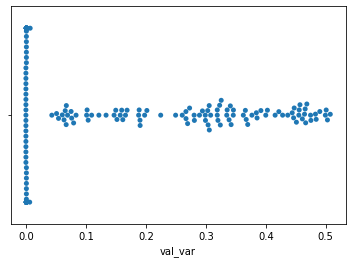

In [ ]:
sns.swarmplot(data=df_variances , x ="val_var")


# Overall Stats


How sparse is the dataset? How much agree, how much disagree, how much pass? Zero is 'passed' or 'did not see the comment to vote on it'. 1 is agree, -1 is disagree

In [ ]:
melted = vals.melt();
all_votes = melted.count();
by_type = melted["value"].value_counts();
total_possible_votes = all_votes["value"];
total_agrees = by_type[1.0];
total_disagrees = by_type[-1.0];
total_without_vote = by_type[0.0];

print("Dimensions of matrix:", df.shape)
print("Dimensions of matrix:", vals.shape)
print("Total number of possible votes:", total_possible_votes)
print("Total number of agrees:", total_agrees)
print("Total number of disagrees:", total_disagrees)
print("Total without vote:", total_without_vote)
print("Percent sparse: ", total_without_vote / total_possible_votes,"%")

## Make sure to check how many people and votes, relative to the total matrix, you are losing given min vote threshold

Dimensions of matrix: (1921, 203)
Dimensions of matrix: (1269, 198)
Total number of possible votes: 251262
Total number of agrees: 30237
Total number of disagrees: 11661
Total without vote: 208097
Percent sparse:  0.8282072100039003 %


**Full participants * comments matrix**

Some things to notice about the matrix: comments are submitted over time, so participants who do not return will only have voted on the statements which were avialable when they arrived.

Long horizontal lines: participants who do return show up as a horizontal line sticking out into otherwise blank areas

Blank vertical lines: most likely statements which were moderated out of the conversation.

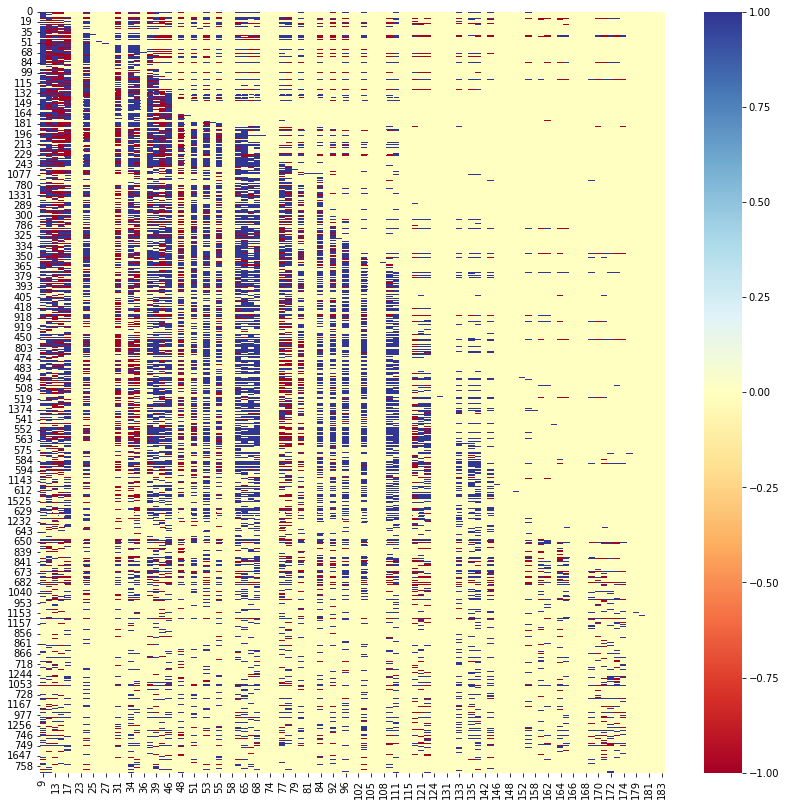

In [ ]:
fig, ax = plt.subplots(figsize=(14,14))
sns.heatmap(vals_all_in, center=0, cmap="RdYlBu", ax=ax)

- The horizontal axis are comments-id from 1-197, some horizontal lines are blank for it's being moderated out.

- The vertical axis are the participants id


**PCA**

Pros:
- Relatively computationally cheap
- Can save embedding model to then project new data points into the reduced space.

Cons:
- Linear reduction limits information that can be captured not as discriminably clusters as other algorithms

PCA with 2 principle components only explain approximate 30% of the variance, while explain near 80% of variance when include 20 principle components.

The graph shows that the seperation is not very boundary-clear


**Uniform manifold approximation and projection**

Pros:
- Non-linear reduction that is computationally faster than t-SNE
- User defined parameter for preserving local or global structure
- Solid theoretical foundations in manifold learning

Cons:
- New, less prevalent algorithm.
- Requires setting hyperparameters that influence quality of the embedding
- Non-deterministic algorithm.

In [ ]:
## leiden graph detect neighbors
## https://leidenalg.readthedocs.io/en/stable/intro.html

A = kneighbors_graph(
    vals_all_in.values,
    8,## n_neighborsint Number of neighbors for each sample.
    mode="connectivity", ## Type of returned matrix: ‘connectivity’ will return the connectivity matrix with ones and zeros, and ‘distance’ will return the distances between neighbors according to the given metric.
    metric="minkowski", ## Metric to use for distance computation. Default is “minkowski”, which results in the standard Euclidean distance when p = 2. See the documentation of scipy.spatial.distance and the metrics listed in distance_metrics for valid metric values.
    p=3, ## Power parameter for the Minkowski metric
    metric_params=None, ## Additional keyword arguments for the metric function.
    include_self=True, ## bool or ‘auto’, default=False
    n_jobs=None) ## The number of parallel jobs to run for neighbors search



In [ ]:
A_array = A.toarray()
A_array

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [ ]:
sources, targets = A.nonzero() ## Return the indices of the elements that are non-zero

In [ ]:
weights = A[sources, targets]
weights

matrix([[1., 1., 1., ..., 1., 1., 1.]])

In [ ]:
if isinstance(weights, np.matrix): # ravel data The isinstance() function returns True if the specified object is of the specified type, otherwise False.
            weights = weights.A1

In [ ]:
## https://igraph.org/python/tutorial/0.9.8/tutorial.html
g = ig.Graph(directed=False) ## The above statement created an undirected graph with no vertices or edges and assigned it to the variable g.
g.add_vertices(A.shape[0])  # each observation is a node
edges = list(zip(sources, targets))
g.add_edges(edges)
g.es['weight'] = weights

In [ ]:
weights = np.array(g.es["weight"]).astype(np.float64)

In [ ]:
part = leidenalg.find_partition(g, leidenalg.ModularityVertexPartition);

In [ ]:
leidenClusters = np.array(part.membership)
leidenClustersStr = [str(i) for i in leidenClusters]

In [ ]:
leidenClustersStr

In [ ]:
## use UMAP technique
reducer = umap.UMAP(
    n_neighbors=10,
    metric='euclidean',
    init='random',
    min_dist=0.1,
    spread=1.0,
    local_connectivity=3.0)

embedding = reducer.fit_transform(vals_all_in.values)

Text(0.5, 1.0, 'Leiden detected communities in UMAP space')

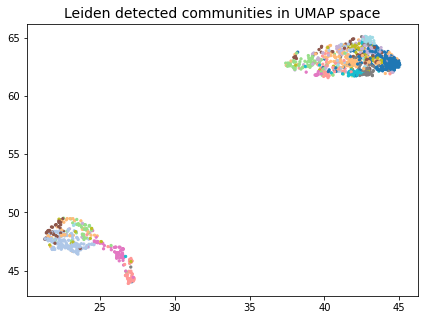

In [ ]:
# Show clusters given umap embedding
fig, ax = plt.subplots(figsize=(7,5))
plt.sca(ax)
ax.scatter(
x=embedding[:,0],
y=embedding[:,1],
c=leidenClusters,
cmap="tab20",
s=5)
ax.set_title("Leiden detected communities in UMAP space", fontsize=14)


In [ ]:
pca_object = PCA(n_components=2) ## pca is apparently different, it wants
pca_object = pca_object.fit(vals_all_in.T) ## .T transposes the matrix (flips it)
coords = pca_object.components_.T ## isolate the coordinates and flip
explained_variance = pca_object.explained_variance_ratio_
explained_variance.sum()

0.33169127006070037

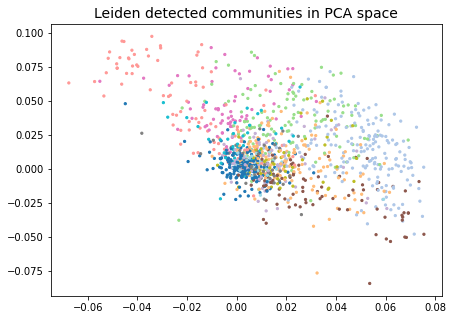

In [ ]:
# Show clusters given pca embedding
fig, ax = plt.subplots(figsize=(7,5))
plt.sca(ax)
ax.scatter(
    x=coords[:,0],
    y=coords[:,1],
    c=leidenClusters,
    cmap="tab20",
    s=5)

ax.set_title("Leiden detected communities in PCA space", fontsize=14)
plt.show()

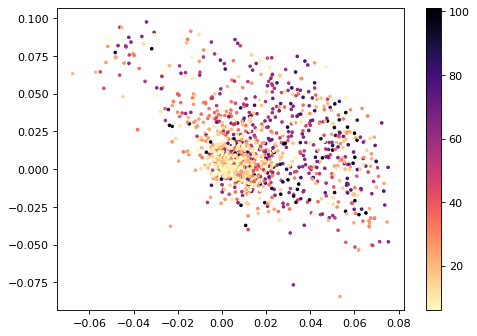

In [ ]:
# number of votes in pca space
plt.figure(figsize=(7, 5), dpi=80)
plt.scatter(
x=coords[:,0],
y=coords[:,1],
c=metadata['n-votes'],
cmap="magma_r",
s=5)
plt.colorbar()

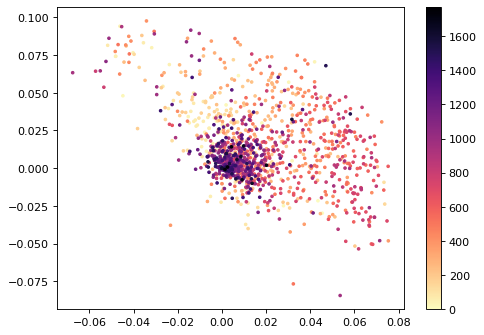

In [ ]:
# when did the participant show up? index
plt.figure(figsize=(7, 5), dpi=80)
plt.scatter(
    x=coords[:,0],
    y=coords[:,1],
    c=metadata.index,
    cmap="magma_r",
    s=5)
plt.colorbar()

In [ ]:
## https://github.com/compdemocracy/analysis/blob/master/umap_metric.py

import numba
import numpy as np

@numba.njit()
def sparsity_aware_dist(a, b):
    n_both_seen = len(a) - (np.isnan(a) | np.isnan(b)).sum()
    return (n_both_seen - (a == b).sum() + 1) / (n_both_seen + 2)

@numba.njit()
def sparsity_aware_dist2(a, b):
    definitive_votes = (a != 0) | (b != 0)
    n_both_seen = definitive_votes.sum()
    return (n_both_seen - (definitive_votes & (a == b)).sum() + 1) / (n_both_seen + 1)

**t-Distributed stochastic neighbor embedding (t-SNE)**

Pros:
- Produces highly clustered, visually striking embeddings
- Non-linear reduction, captures local structure well

Cons:
- Global structure may be lost in favor of preserving local distances
- More computationally expensive
- Requires setting hyperparameters that influence quality of the embedding
- Non-deterministic algorithm


In [ ]:
## https://plotly.com/python/t-sne-and-umap-projections/

def c(comment, coords):
    fig, ax = plt.subplots(figsize=(7,5))
    plt.sca(ax)
    colorMap = {-1:'#A50026', 1:'#313695', 0:'#FEFEC050'}
    ax.scatter(
        x=coords[:,0],
        y=coords[:,1],
        c=vals[str(comment)].apply(lambda x: colorMap[x]),
        s=10
    )
    ax.set_title("\n".join(wrap(str(comment) + "  " + str(df_comments['comment-body'][comment]))), fontsize=14)
    plt.show()

In [ ]:
## Thanks to https://github.com/ciortanmadalina/high_noise_clustering/blob/master/graph-partitioning-louvain.ipynb

## https://leidenalg.readthedocs.io/en/stable/intro.html

## https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.kneighbors_graph.html

## Theory behind leiden algorithm to detect communities

def polis_leiden(dataframe, neighbors):
    A = kneighbors_graph(
        dataframe.values,
        neighbors,
        mode="connectivity",
        metric="minkowski",
        p=3,
        metric_params=None,
        include_self=True,
        n_jobs=None
    )

    sources, targets = A.nonzero()
    weights = A[sources, targets]
    if isinstance(weights, np.matrix): # ravel data
            weights = weights.A1

    g = ig.Graph(directed=False)
    g.add_vertices(A.shape[0])  # each observation is a node
    edges = list(zip(sources, targets))
    g.add_edges(edges)
    g.es['weight'] = weights
    weights = np.array(g.es["weight"]).astype(np.float64)

    part = leidenalg.find_partition(
        g,
        leidenalg.ModularityVertexPartition
    );

    leidenClusters = np.array(part.membership)
    leidenClustersStr = [str(i) for i in leidenClusters]

    #df["leiden"] = leidenClustersStr

    return leidenClusters

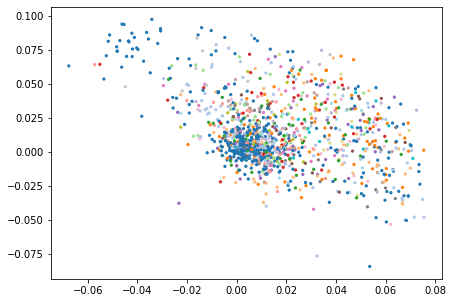

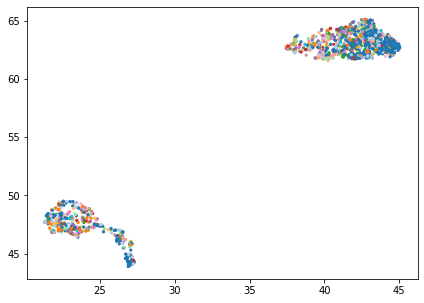

In [ ]:
leidenClusters1 = polis_leiden(vals_opiods, 2)

# Show clusters given pca embedding
fig, ax = plt.subplots(figsize=(7,5))
plt.sca(ax)
ax.scatter(
    x=coords[:,0],
    y=coords[:,1],
    c=leidenClusters1,
    cmap="tab20",
    s=5)



 # Show clusters given umap embedding
fig, ax = plt.subplots(figsize=(7,5))
plt.sca(ax)
ax.scatter(
    x=embedding[:,0],
    y=embedding[:,1],
    c=leidenClusters1,
    cmap="tab20",
    s=5)


In [ ]:
vals_opiods

In [ ]:
 # Show clusters given pca embedding
    fig, ax = plt.subplots(figsize=(7,5))
    plt.sca(ax)
    ax.scatter(
        x=coords[:,0],
        y=coords[:,1],
        c=leidenClusters,
        cmap="tab20",
        s=5)



In [ ]:

    # Show clusters given umap embedding
    fig, ax = plt.subplots(figsize=(7,5))
    plt.sca(ax)
    ax.scatter(
        x=embedding[:,0],
        y=embedding[:,1],
        c=leidenClusters,
        cmap="tab20",
        s=5
    )

In [ ]:

def sparsity_aware_dist(a, b):
    n_both_seen = len(a) - (np.isnan(a) | np.isnan(b)).sum()
    return (n_both_seen - (a == b).sum() + 1) / (n_both_seen + 2)

In [ ]:
def polis_pca(dataframe, components):
    pca_object = PCA(n_components=components) ## pca is apparently different, it wants
    pca_object = pca_object.fit(dataframe.T) ## .T transposes the matrix (flips it)
    coords = pca_object.components_.T ## isolate the coordinates and flip
    explained_variance = pca_object.explained_variance_ratio_

    return coords, explained_variance

In [ ]:
def polis_umap(dataframe, neighbors):
    reducer = umap.UMAP(
        n_neighbors=neighbors,
        metric=sparsity_aware_dist,
        init='random',
        min_dist=0.1,
        spread=1.0,
        local_connectivity=3.0,
    )
    embedding = reducer.fit_transform(dataframe.values)
    # embedding.shape

    return embedding

In [ ]:
def polis_umap(dataframe, neighbors):
    reducer = umap.UMAP(
        n_neighbors=neighbors,
        metric=sparsity_aware_dist,
        init='random',
        min_dist=0.1,
        spread=1.0,
        local_connectivity=3.0,
    )
    embedding = reducer.fit_transform(dataframe.values)
    # embedding.shape

    return embedding

In [ ]:
## Thanks to https://github.com/ciortanmadalina/high_noise_clustering/blob/master/graph-partitioning-louvain.ipynb

def polis_leiden(dataframe, neighbors):
    A = kneighbors_graph(
        dataframe.values,
        neighbors,
        mode="connectivity",
        metric=sparsity_aware_dist,
        p=3,
        metric_params=None,
        include_self=True,
        n_jobs=None
    )
    print(dataframe.values.shape)
    print(A.shape)

    sources, targets = A.nonzero()
    weights = A[sources, targets]
    if isinstance(weights, np.matrix): # ravel data
            weights = weights.A1

    g = ig.Graph(directed=False)
    g.add_vertices(A.shape[0])  # each observation is a node
    edges = list(zip(sources, targets))
    g.add_edges(edges)
    g.es['weight'] = weights
    weights = np.array(g.es["weight"]).astype(np.float64)

    part = leidenalg.find_partition(
        g,
        leidenalg.ModularityVertexPartition
    );

    leidenClusters = np.array(part.membership)
    leidenClustersStr = [str(i) for i in leidenClusters]

    from collections import Counter
    print(len(Counter(part.membership).keys()))

    df["leiden"] = leidenClustersStr

    return leidenClusters

In [ ]:
def polis_subconversation(dataframe, comments):
    coords, explained_variance = polis_pca(dataframe, 2)
    print("Explained variance:", explained_variance)

    embedding = polis_umap(dataframe, 10)

    leidenClusters = polis_leiden(dataframe, 8)


    # Show clusters given umap embedding
    fig, ax = plt.subplots(figsize=(7,5))
    plt.sca(ax)
    ax.scatter(
        x=embedding[:,0],
        y=embedding[:,1],
        c=leidenClusters,
        cmap="tab20",
        s=5
    )
    ax.set_title("Leiden detected communities in UMAP space", fontsize=14)


    # Show clusters given pca embedding
    fig, ax = plt.subplots(figsize=(7,5))
    plt.sca(ax)
    ax.scatter(
        x=coords[:,0],
        y=coords[:,1],
        c=leidenClusters,
        cmap="tab20",
        s=5
    )

    ax.set_title("Leiden detected communities in PCA space", fontsize=14)
    plt.show()

    # number of votes in pca space
    plt.figure(figsize=(7, 5), dpi=80)
    plt.scatter(
        x=coords[:,0],
        y=coords[:,1],
        c=metadata['n-votes'],
        cmap="magma_r",
        s=5
    )
    plt.colorbar()

    # when did the participant show up? index
    plt.figure(figsize=(7, 5), dpi=80)
    plt.scatter(
        x=coords[:,0],
        y=coords[:,1],
        c=metadata.index,
        cmap="magma_r",
        s=5
    )
    plt.colorbar()

    # PCA for COMMENTS

    coords, explained_variance = polis_pca(dataframe.T, 2)

    plt.figure(figsize=(7, 5), dpi=80)
    plt.scatter(
        x=coords[:,0],
        y=coords[:,1],
#         c=,
        cmap="magma_r",
        s=5
    )



#     plt.colorbar()

#     # Show clustermap
#     dataframe['leiden_cluster_assignments'] = leidenClusters
#     clusters_by_comments_means = dataframe.groupby('leiden_cluster_assignments').agg('mean')

#     #sns.heatmap(clusters_by_comments_means, cmap="RdYlBu")
#     sns.clustermap(clusters_by_comments_means, cmap="RdYlBu", figsize=(15,15))

    for x in comments:
        c(x, coords)
        c(x, embedding)


In [ ]:
def polis_heatmap(__dataframe):
    leidenClusters = polis_leiden(__dataframe, 8)

    # Show clustermap
    __dataframe['leiden_cluster_assignments'] = leidenClusters
    clusters_by_comments_means = __dataframe.groupby('leiden_cluster_assignments').agg('mean').T

    index_to_label = df_comments['comment-body'].to_dict() # {index: label}

    clustergrid = sns.clustermap(clusters_by_comments_means, cmap="RdBu", figsize=(10,10), )

    ax = clustergrid.ax_heatmap
    new_labels = [index_to_label[str(idx._text)] for idx in ax.get_yticklabels()] # [ label0, label1, label2, ...]
    ax.set_yticklabels(new_labels, rotation=0, fontsize=10)

K-neighbor and two-layer graph approaches

* K-neighbor graph of the participants votes matrix is given as input to the Leiden algorithm for community detection. However, the quality of result is low, if the adjacency matrix is given as-is in one-layer format, as

In [ ]:
def generate_pos_neg_graphs(dataframe):
    # Generate two-layer multiplex bipartite graphs using dataframe data
    #
    # Parameters:
    #   dataframe: a participant-votes dataframe
    #
    # Returns:
    #   G_pos: participant-votes bipartite graph of positive votes (i.e. positive layer)
    #   G_neg: participant-votes bipartite graph of negative votes (i.e. negative layer)
    A = dataframe.values

    # Convert 'bipartite' matrix A (rows=participants, columns=votes)
    # into unipartite form, by adding votes rows and participant columns.
    #
    # The new rectangular matrix A_sym can be written in block form as:
    # A_sym = [ 0     A ]
    #         [ A.T   0 ]
    A_sym = np.block([[np.zeros((A.shape[0], A.shape[0])), A], [np.transpose(A), np.zeros((A.shape[1], A.shape[1]))] ])

    # G_pos includes only positive edges (positive weights in A_sym)
    G_pos = ig.Graph.Adjacency((A_sym > 0).tolist(), mode="undirected")
    # G_neg includes only negative edges (negative weights in A_sym)
    G_neg = ig.Graph.Adjacency((A_sym < 0).tolist(), mode="undirected")

    # Partition of nodes in two classes (bipartite graph) - optional info
    # Class 0: participants - first A.shape[0] nodes
    # Class 1: votes - subsequent A.shape[1] nodes
    G_pos.vs['type'] = np.block([np.ones(A.shape[0]), np.zeros(A.shape[1])])
    G_neg.vs['type'] = np.block([np.ones(A.shape[0]), np.zeros(A.shape[1])])

    return G_pos, G_neg

def generate_dual_graph(dataframe):
    # Generate one-layer bipartite graph using dataframe data
    #
    # Parameters:
    #   dataframe: a participant-votes dataframe
    #
    # Returns:
    #   G: participant-votes bipartite graph of pos/neg votes (i.e. one layer)

    A = dataframe.values

    A_sym = np.block([[np.zeros((A.shape[0], A.shape[0])), A], [np.transpose(A), np.zeros((A.shape[1], A.shape[1]))] ])
    g = ig.Graph.Adjacency((A_sym != 0).tolist(), mode="undirected")
    g.es['weight'] = A_sym[A_sym.nonzero()] # Possibly not needed

    # Partition of nodes in two classes (bipartite graph) - optional info
    # Class 0: participants - first A.shape[0] nodes
    # Class 1: votes - subsequent A.shape[1] nodes
    g.vs['type'] = np.block([np.ones(A.shape[0]), np.zeros(A.shape[1])])

    # Naming nodes for easy retrieval
    for idx, v in enumerate(g.vs):
      v['name'] = idx

    return g

In [ ]:
def generate_kneighbors_graph(dataframe, neighbors):
    # Generate k-neighbors unipartite graphs using dataframe data
    #
    # Parameters:
    #   dataframe: a participant-votes dataframe
    #   neighbors (int): number of neighbors (k)
    #
    # Returns:
    #   G: participant-participant unipartite graph of k-neighbors connectivity

    A = kneighbors_graph(
        dataframe.values,
        neighbors,
        mode="connectivity",
        metric=sparsity_aware_dist,
        p=3,
        metric_params=None,
        include_self=True,
        n_jobs=None
    )
    print("Dataframe shape: {}".format(dataframe.values.shape))
    print("Kneighbor graph shape: {}".format(A.shape))

    sources, targets = A.nonzero()
    weights = A[sources, targets]
    if isinstance(weights, np.matrix): # ravel data
            weights = weights.A1

    g = ig.Graph(directed=False)
    g.add_vertices(A.shape[0])  # each observation is a node
    edges = list(zip(sources, targets))
    g.add_edges(edges)
    g.es['weight'] = weights
    weights = np.array(g.es["weight"]).astype(np.float64)

    return g

#generate_kneighbors_graph(vals_all_in, 8)

In [ ]:
def polis_leiden_onelayer(graph, optimizationfunction):
    # Calculate clusters using Leiden algorithm for one-layer graph
    #
    # Parameters:
    #   graph: the graph to detect communities on
    #   optimizationfunction: the optimization function for Leiden alg
    #
    # Returns:
    #   leidenClusters: the partition sequence detected by Leiden alg

    part = leidenalg.find_partition(
        graph,
        optimizationfunction
    );

    leidenClusters = np.array(part.membership)

    # Print total nr of communities detected
    from collections import Counter
    print("Nr of communities detected: {}".format(len(Counter(part.membership).keys())))

    return leidenClusters

def polis_leiden_onelayer_iterative(graph, optimizationfunction, n_iterations):
    # Calculate clusters using Leiden algorithm for one-layer graph, iteratively
    #
    # Parameters:
    #   graph: the graph to detect communities on
    #   optimizationfunction: the optimization function for Leiden alg
    #   n_iterations (int): number of iterations
    #
    # Returns:
    #   leidenClusters: the partition sequence detected by Leiden alg

    part = optimizationfunction(graph)
    diff = leidenalg.Optimiser().optimise_partition(part, n_iterations)

    leidenClusters = np.array(part.membership)

    # Print total nr of communities detected
    from collections import Counter
    print("Nr of communities detected after {} iterations: {}".format(
        n_iterations,
        len(Counter(part.membership).keys())))

    return leidenClusters

In [ ]:
def polis_leiden_twolayers(G_pos, G_neg, optimizationfunction):
    # Calculate clusters using Leiden algorithm for two-layer graph
    #
    # Parameters:
    #   G_pos: the positive (layer of the) graph
    #   G_neg: the negative (layer of the) graph
    #   optimizationfunction: the optimization function for Leiden alg
    #
    # Returns:
    #   leidenClusters: the partition sequence detected by Leiden alg

    optimiser = leidenalg.Optimiser()
    partition_pos = optimizationfunction(G_pos)
    partition_neg = optimizationfunction(G_neg)
    # Both layers are fed into Leiden. layer_weights=[1,-1] penalize negative layer
    # See also 4.1.1 in https://readthedocs.org/projects/leidenalg/downloads/pdf/latest/
    diff = optimiser.optimise_partition_multiplex(
                   partitions=[partition_pos, partition_neg],
                   layer_weights=[1,-1])

    leidenClusters = np.array(partition_pos.membership)

    # Print the sequence and nr of communities detected
    from collections import Counter
    print("Nr of communities detected: {}".format(len(Counter(partition_pos.membership).keys())))
    print("Seq of communities detected: {}".format(Counter(np.array(partition_pos.membership))))

    return leidenClusters
'''
from collections import Counter
G_pos, G_neg = generate_pos_neg_graphs(vals_all_in)
lc = polis_leiden_twolayers(G_pos, G_neg, leidenalg.ModularityVertexPartition)
lc_participants = lc[:vals_all_in.shape[0]]
'''
def polis_leiden_twolayers_iterative(G_pos, G_neg, optimizationfunction, n_iterations):
    # Calculate clusters using Leiden algorithm for two-layer graph, iterative
    #
    # Parameters:
    #   G_pos: the positive (layer of the) graph
    #   G_neg: the negative (layer of the) graph
    #   optimizationfunction: the optimization function for Leiden alg
    #   n_iterations (int): number of iterations
    #
    # Returns:
    #   leidenClusters: the partition sequence detected by Leiden alg

    optimiser = leidenalg.Optimiser()
    partition_pos = optimizationfunction(G_pos)
    partition_neg = optimizationfunction(G_neg)
    diff = optimiser.optimise_partition_multiplex(
                   partitions=[partition_pos, partition_neg],
                   layer_weights=[1,-1],
                   n_iterations=n_iterations)

    leidenClusters = np.array(partition_pos.membership)

    # Print the sequence and nr of communities detected
    from collections import Counter
    print("Nr of communities detected after {} iterations: {}".format(
        n_iterations,
        len(Counter(partition_pos.membership).keys())))
    print("Seq of communities detectedafter {} iterations: {}".format(
        n_iterations,
        Counter(np.array(partition_pos.membership))))

    return leidenClusters

In [ ]:
def polis_leiden_twolayers_bipartite(G_pos, G_neg):
    # DO NOT USE! Currently not working as intended!
    #
    # Calculate clusters using Leiden algorithm for two-layer bipartite graph
    #
    # NB: Unlike the other polis_leiden_* functions, this always optimizes using modularity
    #
    # Parameters:
    #   G_pos: the positive (layer of the) graph
    #   G_neg: the negative (layer of the) graph
    #
    # Returns:
    #   leidenClusters: the partition sequence detected by Leiden alg

    optimiser = leidenalg.Optimiser()
    part_pos_0, part_pos_1, part_pos_2 = leidenalg.CPMVertexPartition.Bipartite(G_pos, 0.01, 0, 0, True);
    part_neg_0, part_neg_1, part_neg_2 = leidenalg.CPMVertexPartition.Bipartite(G_neg, 0.01, 0, 0, True);
    # See also https://leidenalg.readthedocs.io/en/stable/reference.html#leidenalg.CPMVertexPartition.Bipartite
    diff = optimiser.optimise_partition_multiplex(
        partitions=[part_pos_0, part_pos_1, part_pos_2, part_neg_0, part_neg_1, part_neg_2],
        layer_weights=[1,-1,-1,-1,-1,-1]
        )

    leidenClusters = np.array(part_pos_0.membership)

    # Print the sequence and nr of communities detected
    from collections import Counter
    print("Nr of communities detected: {}".format(len(Counter(part_pos_0.membership).keys())))
    print("Seq of communities detected: {}".format(Counter(np.array(part_pos_0.membership))))

    return leidenClusters

In [ ]:
def show_embedding(space, color, title):
    # Helper function to plot community data as color on an embedding space
    #
    # Parameters:
    #   space: the embedding space to plot data on (e.g. UMAP, PCA)
    #   color: the community data to plot as color in the embedding
    #   title: the plot's title

    fig, ax = plt.subplots(figsize=(7,5))
    plt.sca(ax)
    # NB: palette contains only 20 colors ('tab20')
    # (User needs to artificially limit communities to <20)
    ax.scatter(
        x=space[:,0],
        y=space[:,1],
        c=color,
        cmap="tab20",
        s=5
    )
    ax.set_title(title, fontsize=14)
    plt.show()

def polis_subconversation_alt(dataframe, comments):
    # Experimentation with and plotting of different community detection
    # scenarios, on variations of the same dataset.
    #
    # (Approximate stand-in for original polis_subconversation function)
    #
    # Parameters:
    #   dataframe: a participant-votes dataframe
    #   comments: not used here

    embedding = polis_umap(dataframe, 10)
    coords, explained_variance = polis_pca(dataframe, 2)
    print("Explained variance:", explained_variance)

    #leidenClusters = polis_leiden(dataframe, 8)
    #show_embedding(embedding, leidenClusters, "Leiden detected communities in UMAP space")
    #show_embedding(coords, leidenClusters, "Leiden detected communities in PCA space")

    ########################
    # K-neighbors, one layer
    ########################
    G_kneighbors = generate_kneighbors_graph(dataframe, 8)
    lc = polis_leiden_onelayer(G_kneighbors, leidenalg.ModularityVertexPartition)
    show_embedding(embedding, lc, "Leiden, UMAP, kneighbor graph, one layer, modularity")
    show_embedding(coords, lc, "Leiden, PCA, kneighbor graph, , one layer, modularity")

    '''
    lc = polis_leiden_onelayer_iterative(G_kneighbors, leidenalg.ModularityVertexPartition, 10)
    show_embedding(embedding, lc, "Leiden, UMAP, kneighbor graph, one layer, modularity, iterative")
    show_embedding(coords, lc, "Leiden, PCA, kneighbor graph, , one layer, modularity, iterative")

    lc = polis_leiden_onelayer(G_kneighbors, leidenalg.CPMVertexPartition)
    show_embedding(embedding, lc, "Leiden, UMAP, kneighbor graph, one layer, CPM")
    show_embedding(coords, lc, "Leiden, PCA, kneighbor graph, one layer, CPM")

    lc = polis_leiden_onelayer_iterative(G_kneighbors, leidenalg.CPMVertexPartition, 10)
    show_embedding(embedding, lc, "Leiden, UMAP, kneighbor graph, one layer, CPM, iterative")
    show_embedding(coords, lc, "Leiden, PCA, kneighbor graph, one layer, CPM, iterative")
    '''

    #############################
    # Adjacency matrix, one layer
    #############################
    G = generate_dual_graph(dataframe)
    lc = polis_leiden_onelayer(G, leidenalg.ModularityVertexPartition)
    # Adjustment in case of > 20 communities (i.e. limited color palette)
    lc_show = []
    for x in lc[:embedding.shape[0]]:
      lc_show.append(x) if x < 20 else lc_show.append(20)
    show_embedding(embedding, lc_show, "Leiden, UMAP, adjacency matrix , one layer, modularity")
    show_embedding(coords, lc_show, "Leiden, PCA, adjacency matrix, one layer, modularity")

    '''
    lc = polis_leiden_onelayer_iterative(G, leidenalg.ModularityVertexPartition, 10)
    show_embedding(embedding, lc[:embedding.shape[0]], "Leiden, UMAP, adjacency matrix, one layer, modularity, iterative")
    show_embedding(coords, lc[:coords.shape[0]], "Leiden, PCA, adjacency matrix, one layer, modularity, iterative")

    lc = polis_leiden_onelayer(G, leidenalg.CPMVertexPartition)
    show_embedding(embedding, lc[:embedding.shape[0]], "Leiden, UMAP, adjacency matrix, one layer, CPM")
    show_embedding(coords, lc[:coords.shape[0]], "Leiden, PCA, adjacency matrix, one layer, CPM")

    lc = polis_leiden_onelayer_iterative(G, leidenalg.CPMVertexPartition, 10)
    show_embedding(embedding, lc[:embedding.shape[0]], "Leiden, UMAP, adjacency matrix, one layer, CPM, iterative")
    show_embedding(coords, lc[:coords.shape[0]], "Leiden, PCA, adjacency matrix, one layer, CPM, iterative")
    '''

    ##############################
    # Adjacency matrix, two layers
    ##############################
    G_pos, G_neg = generate_pos_neg_graphs(dataframe)
    lc = polis_leiden_twolayers(G_pos, G_neg, leidenalg.ModularityVertexPartition)
    # Adjustment in case of > 20 communities (i.e. limited color pallete)
    lc_show = []
    for x in lc[:embedding.shape[0]]:
      lc_show.append(x) if x < 20 else lc_show.append(20)
    show_embedding(embedding, lc_show, "Leiden, UMAP, adjacency matrix , two layers, modularity")
    show_embedding(coords, lc_show, "Leiden, PCA, adjacency matrix, two layers, modularity")
    '''
    lc = polis_leiden_twolayers_iterative(G_pos, G_neg, leidenalg.ModularityVertexPartition, 10)
    show_embedding(embedding, lc[:embedding.shape[0]], "Leiden, UMAP, adjacency matrix, two layers, modularity, iterative")
    show_embedding(coords, lc[:coords.shape[0]], "Leiden, PCA, adjacency matrix, two layers, modularity, iterative")

    lc = polis_leiden_twolayers(G_pos, G_neg, leidenalg.CPMVertexPartition)
    show_embedding(embedding, lc[:embedding.shape[0]], "Leiden, UMAP, adjacency matrix, two layers, CPM")
    show_embedding(coords, lc[:coords.shape[0]], "Leiden, PCA, adjacency matrix, two layers, CPM")

    lc = polis_leiden_twolayers_iterative(G_pos, G_neg, leidenalg.CPMVertexPartition, 10)
    show_embedding(embedding, lc[:embedding.shape[0]], "Leiden, UMAP, adjacency matrix, two layers, CPM, iterative")
    show_embedding(coords, lc[:coords.shape[0]], "Leiden, PCA, adjacency matrix, two layers, CPM, iterative")
    '''

    #########################################
    # Adjacency matrix, two layers, bipartite
    #########################################
    '''
    G_pos, G_neg = generate_pos_neg_graphs(dataframe)
    lc = polis_leiden_twolayers_bipartite(G_pos, G_neg)
    # Adjustment in case of > 20 communities (i.e. limited color palette)
    lc_show = []
    for x in lc[:embedding.shape[0]]:
      lc_show.append(x) if x < 20 else lc_show.append(20)
    show_embedding(embedding, lc_show, "Leiden, UMAP, adjacency matrix , two layers, modularity, bipartite")
    show_embedding(coords, lc_show, "Leiden, PCA, adjacency matrix, two layers, modularity, bipartite")
    '''

    return lc, G



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1773: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  "custom distance metric does not return gradient; inverse_transform will be unavailable. "


Explained variance: [0.22076561 0.11092566]
Dataframe shape: (1269, 99)
Kneighbor graph shape: (1269, 1269)
Nr of communities detected: 12


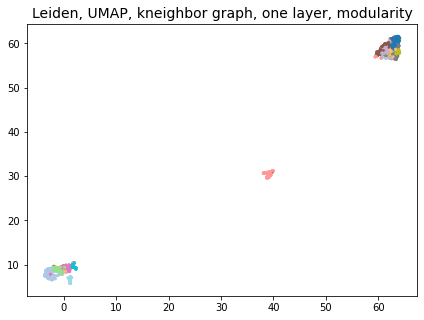

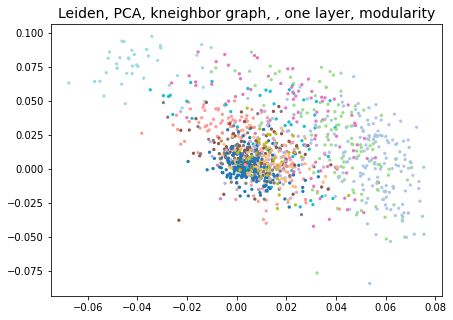

Nr of communities detected: 57


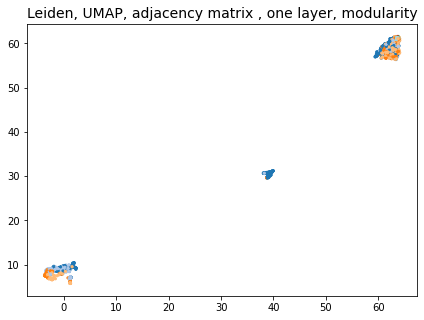

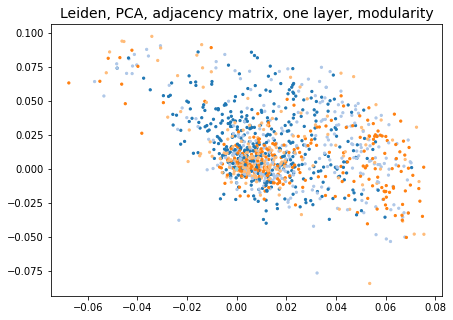

Nr of communities detected: 93
Seq of communities detected: Counter({0: 673, 1: 456, 2: 118, 3: 23, 4: 3, 5: 2, 6: 2, 10: 2, 7: 2, 8: 2, 9: 2, 11: 2, 12: 1, 13: 1, 14: 1, 15: 1, 89: 1, 87: 1, 16: 1, 17: 1, 18: 1, 19: 1, 85: 1, 20: 1, 21: 1, 23: 1, 24: 1, 83: 1, 25: 1, 92: 1, 26: 1, 90: 1, 86: 1, 88: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 72: 1, 34: 1, 22: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 69: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 78: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 70: 1, 75: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 91: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 71: 1, 73: 1, 74: 1, 76: 1, 77: 1, 79: 1, 80: 1, 81: 1, 82: 1, 84: 1})


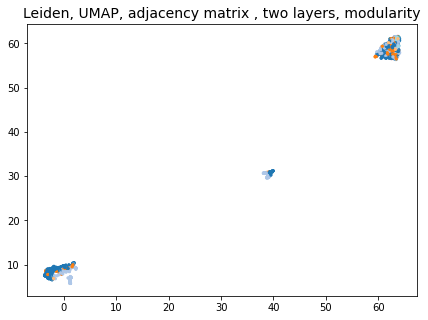

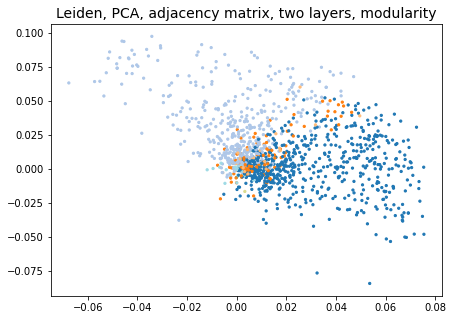

In [ ]:
leidenClust, G = polis_subconversation_alt(vals_all_in, high_variance)

**Is the space explained by how much people vote?**

In this chart, we take the PCA coordinates and color the participant locations by the number of total votes. Hopefully, it looks random. If it doesn't, we might imagine the following scenario:

1. 1000 people vote, and there are very few controversial statements. They do not return.
2. 1 person submits a statement which is incredibly controversial.
3. 1000 more people vote, the space begins to take on structure, PCA is closely linked to vote count.

We know this scenario - that voters don't see controversial comments - happens. Polis mitigates in two ways:

- polis eliminates participants who don't vote at least 7 times from the analysis
- polis shows several highly controversial comments (large egeinvalue) in the first 10 comments participants see


In [ ]:
coords, embedding = polis_pca(vals_all_in, 2)

plt.figure(figsize=(7, 5), dpi=80)
plt.scatter(
    x=coords[:,0],
    y=coords[:,1],
    c=metadata['n-votes'],
    cmap="magma_r",
    s=5
)
plt.colorbar()

NameError: ignored

In [ ]:
vals_all_in

,9,12,13,15,17,22,23,24,25,26,...,172,173,174,176,179,180,181,182,183,leiden_cluster_assignments
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,0.0,0.0,-1.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2,1.0,1.0,-1.0,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,1.0,0.0,-1.0,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
897,1.0,0.0,-1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
1125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
1261,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


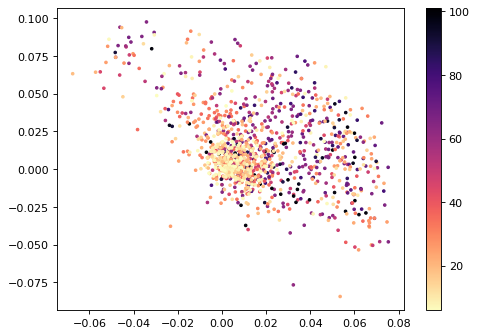

In [ ]:
### https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

def polis_pca(dataframe, components):
    pca_object = PCA(n_components=components) ## pca is apparently different, it wants
    pca_object = pca_object.fit(dataframe.T) ## .T transposes the matrix (flips it)
    coords = pca_object.components_.T ## isolate the coordinates and flip
    explained_variance = pca_object.explained_variance_ratio_

    return coords, explained_variance


coords, embedding = polis_pca(vals_all_in, 2)

plt.figure(figsize=(7, 5), dpi=80)
plt.scatter(
    x=coords[:,0],
    y=coords[:,1],
    c=metadata['n-votes'],
    cmap="magma_r",
    s=5
)
plt.colorbar()




### **High Variance**

In [ ]:
polis_subconversation(vals_all_in, high_variance)

NameError: ignored

###**Consensus**

Explained variance: [0.68796733 0.06721623]


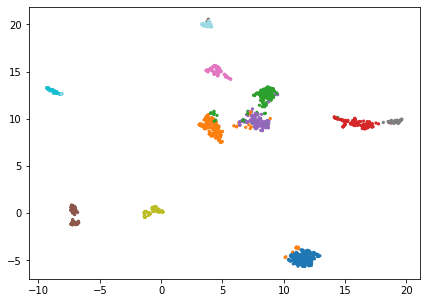

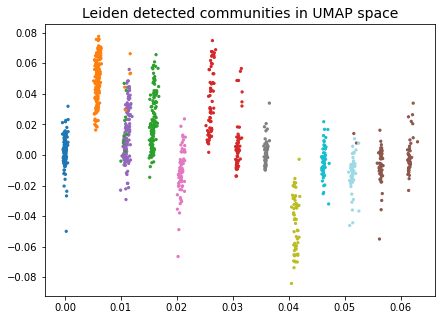

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


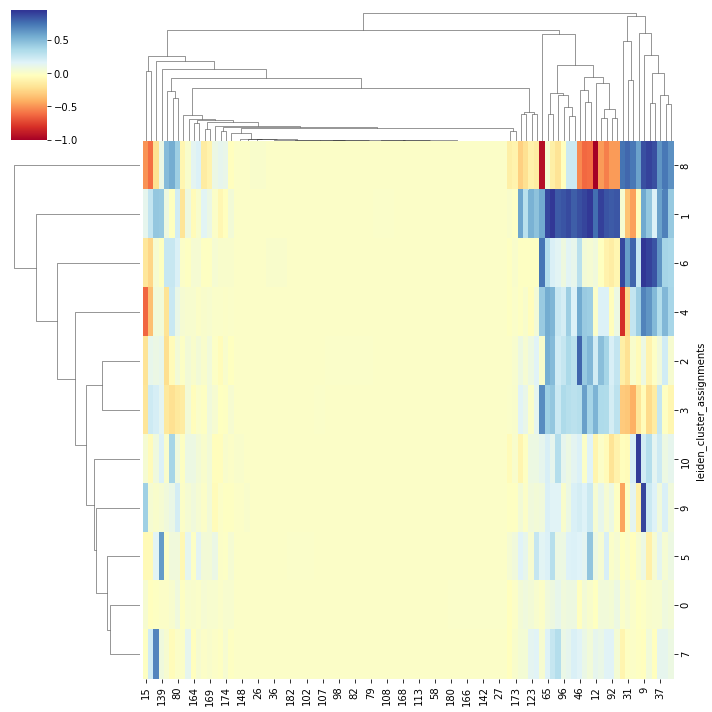

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25105 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 35258 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24471 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20497 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 30495 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 30340 missing from current font.
  font.set_

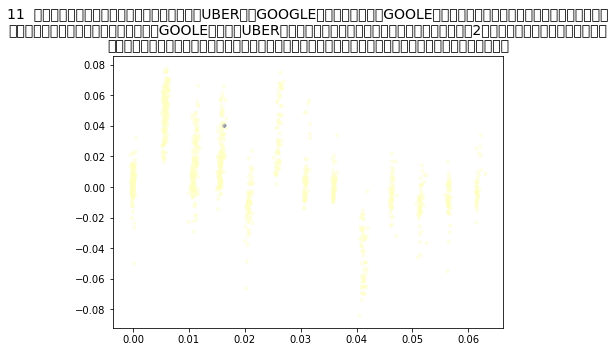

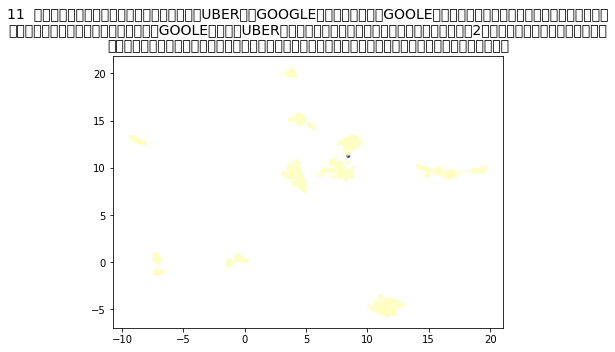

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23481 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 35377 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 40723 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21237 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23384 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21050 missing from current font.
  font.set_

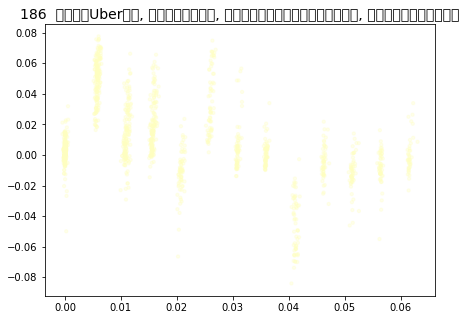

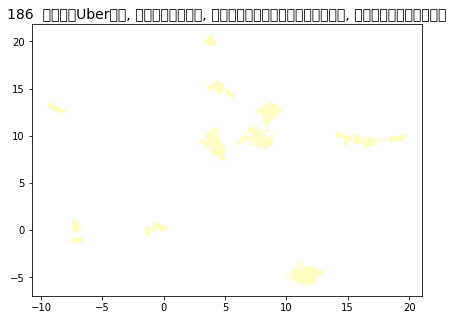

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 36635 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 36074 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26222 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 36941 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 19968 missing from current font.
  font.set_

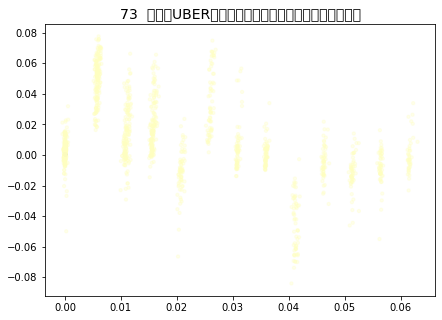

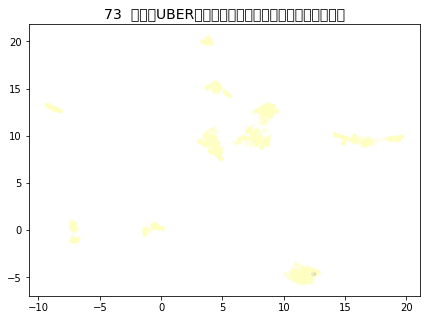

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 35469 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 28858 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32773 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 36000 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 36215 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20445 missing from current font.
  font.set_

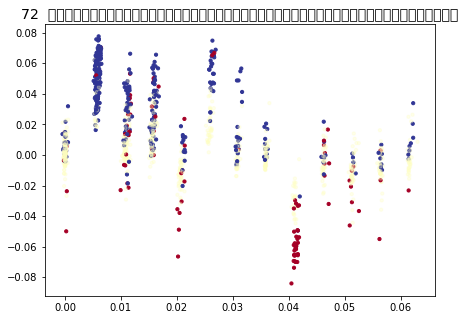

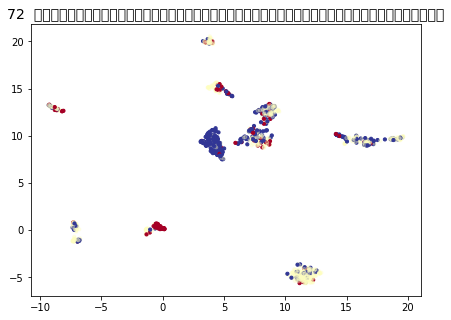

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21483 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 27966 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 35527 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 19978 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 29992 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 38290 missing from current font.
  font.set_

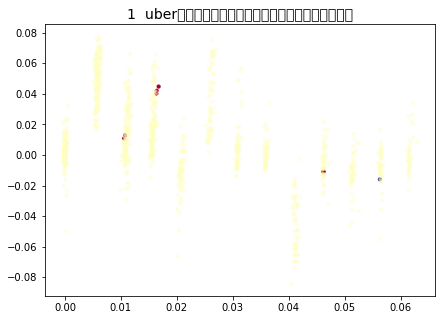

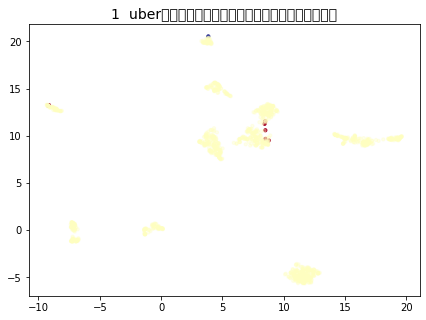

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32147 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 28639 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24565 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 19988 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 38928 missing from current font.
  font.set_

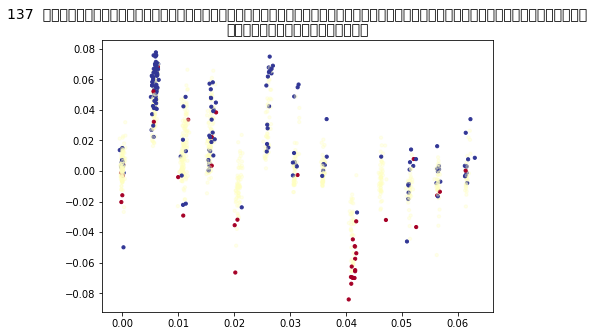

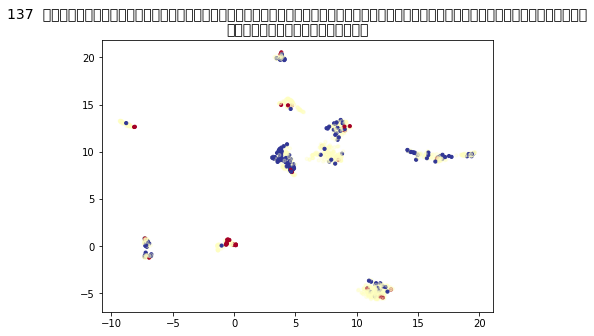

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 39006 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20284 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25910 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 27010 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 39006 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20284 missing from current font.
  font.set_te

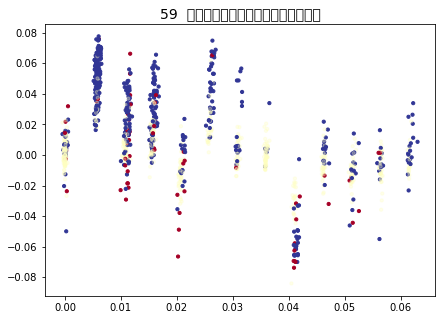

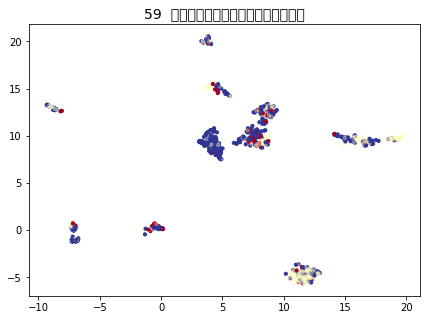

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 30456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21934 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20301 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 35657 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20351 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 28982 missing from current font.
  font.set_

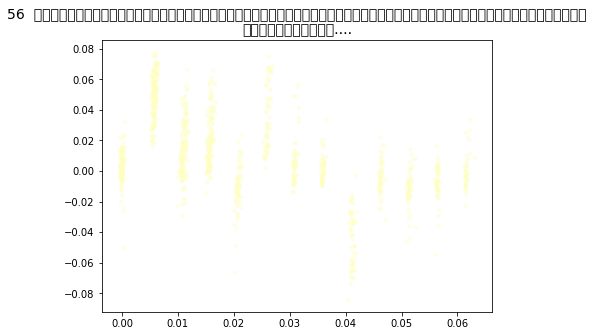

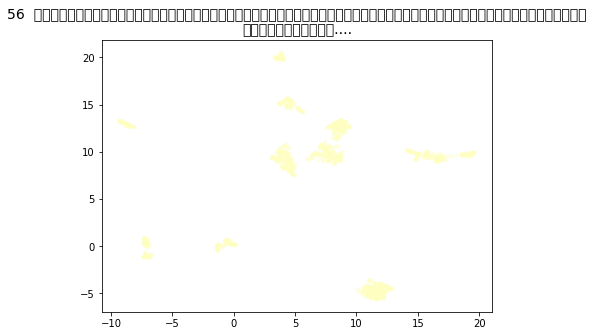

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 38570 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 38570 missing from current font.
  font.set_text(s, 0, flags=flags)


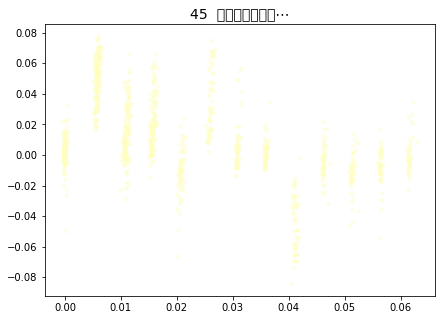

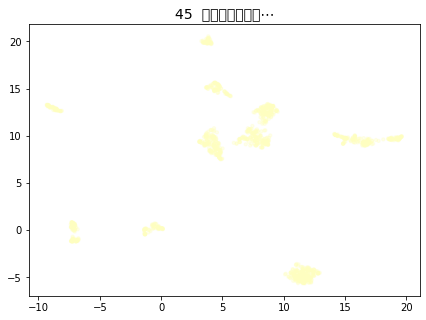

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 27835 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 31639 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22240 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 38577 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 34255 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 33879 missing from current font.
  font.set_

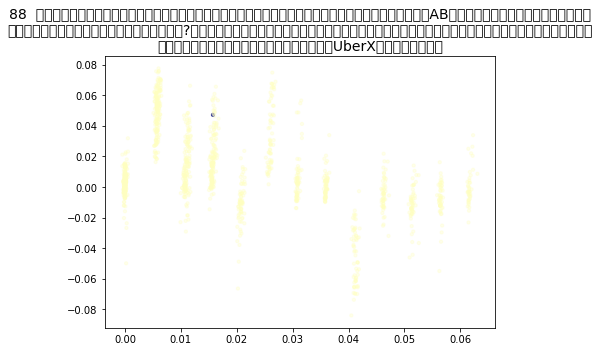

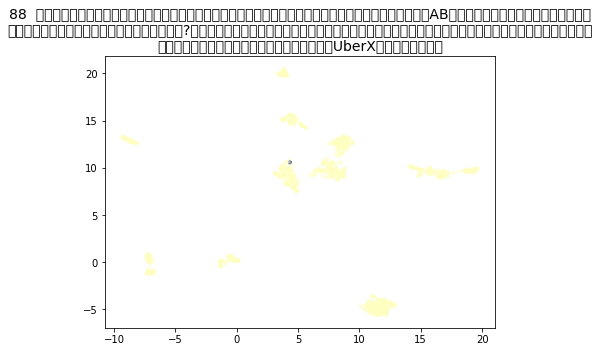

In [ ]:
polis_subconversation(vals_all_in, statements_consensus)


###**Opiods**

In [ ]:
polis_subconversation(vals_opiods, statements_opiods)


NameError: ignored

##**Homelessness**

In [ ]:
polis_subconversation(vals_homelessness, statements_about_homelessness)

##**ALL**

Explained variance: [0.59601028 0.08879061]


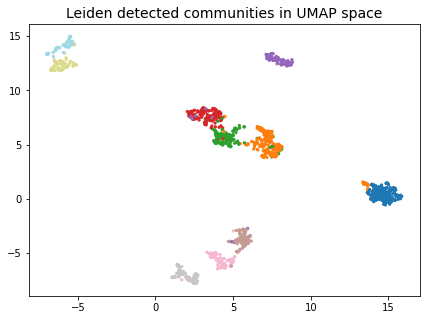

In [ ]:
coords, explained_variance = polis_pca(vals_all_in, 2)
print("Explained variance:", explained_variance)

embedding = polis_umap(vals_all_in, 4)

leidenClusters = polis_leiden(vals_all_in, 8)

# Show clusters given umap embedding
fig, ax = plt.subplots(figsize=(7,5))
plt.sca(ax)
ax.scatter(
    x=embedding[:,0],
    y=embedding[:,1],
    c=leidenClusters,
    cmap="tab20",
    s=5
)

ax.set_title("Leiden detected communities in UMAP space", fontsize=14)
plt.show()

for x in statements_all_in:
    if int(x) < 5:
        c(x, coords)
        c(x, embedding)